In [73]:
from transformers import RobertaTokenizer, TFRobertaModel
import datasets
import tensorflow as tf
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt

In [42]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

2022-07-11 21:47:14.916123: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 21:47:14.936470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 21:47:14.936588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 21:47:14.937172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
outputs = model(inputs)

last_hidden_states = outputs.last_hidden_state

In [4]:
inputs

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[    0, 31414,     6,   127,  2335,    16, 11962,     2]],
      dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [5]:
outputs

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[-0.04778079,  0.08856517, -0.00979672, ..., -0.05444449,
         -0.06716338, -0.00391623],
        [-0.07121383,  0.01499833, -0.1298776 , ...,  0.06383334,
          0.02963825, -0.08603133],
        [ 0.09055017,  0.14373958,  0.08283181, ...,  0.05086066,
         -0.03197741, -0.04901589],
        ...,
        [ 0.08531624,  0.21548253,  0.08490154, ..., -0.11496733,
          0.03299987, -0.07903446],
        [ 0.16793376,  0.128793  ,  0.00646019, ...,  0.03671372,
         -0.06305141,  0.02762577],
        [-0.04356978,  0.08920526, -0.03888651, ..., -0.09573355,
         -0.07437792, -0.02838535]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-3.20835412e-03, -2.19398811e-01, -2.10875914e-01,
        -7.67211840e-02,  1.20515734e-01,  2.04878107e-01,
         2.60702759e-01, -8.43434557e-02, -7.25212172e-0

In [23]:
MAX_LENGTH = 250

In [83]:
def build_base_roberta(learning_rate = 0.00001,
                      dropout=0.3,
                      hidden_size=100):
    
    model = TFRobertaModel.from_pretrained("roberta-base")
    
    input_ids = tf.keras.layers.Input(shape=(100,), dtype=tf.int64, name='input_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(100,), dtype=tf.int64, name='attention_mask_layer')
    

    bert_inputs = {'input_ids': input_ids,
                   'attention_mask': attention_mask}         

    bert_out = model(bert_inputs)[1]
    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(bert_out)
    dropped = tf.keras.layers.Dropout(dropout)(hidden)  

    classification = tf.keras.layers.Dense(1, activation='softmax',name='classification_layer')(dropped)

    
    detection_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification])
    
    detection_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                            loss='binary_crossentropy', 
                            metrics='accuracy') 
    return detection_model
    

In [29]:
wiki = datasets.load_dataset("wikitext",'wikitext-103-v1')

Reusing dataset wikitext (/home/brody/.cache/huggingface/datasets/wikitext/wikitext-103-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)
100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 28.50it/s]


In [7]:
with open('/home/brody/school/w266/data/generated_wiki_text.data', 'rb') as f:
    generated_texts = pickle.load(f)

In [24]:
split_gen = []
for i in generated_texts:
    split_gen.extend(i.split('\n'))

In [25]:
cleaned_gen = []
for example in split_gen:
    if len(example) >= MAX_LENGTH:
        cleaned_gen.append(example[:MAX_LENGTH])

In [26]:
print(len(cleaned_gen))
random.shuffle(cleaned_gen)

1292


In [34]:
cleaned_wiki = []
i = 0
while len(cleaned_wiki) < len(cleaned_gen):
    example = wiki['train']['text'][i]
    if len(example) >= MAX_LENGTH:
        cleaned_wiki.append(example[:MAX_LENGTH])
    i+=1
    if i %100 == 0:
        print(i)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500


In [35]:
len(cleaned_wiki)

1292

In [36]:
with open('/home/brody/school/w266/data/cleaned_generated_text.data', 'wb') as f:
    pickle.dump(cleaned_gen, f)
with open('/home/brody/school/w266/data/cleaned_wiki_text.data', 'wb') as f:
    pickle.dump(cleaned_wiki, f)

In [37]:
wiki_train_labels = np.array([0]*(len(cleaned_wiki)-250) + [1]*(len(cleaned_gen)-250))
wiki_val_labels = np.array([0]*250+[1]*250)

In [39]:
train_texts = cleaned_wiki[:-250] + cleaned_gen[:-250]
val_texts = cleaned_wiki[-250:] + cleaned_gen[-250:]

In [60]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=100, return_tensors='tf')
valid_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=100, return_tensors='tf')

In [61]:
lengths = set()
for i in val_texts:
    lengths.add(len(i))
print(lengths)
print(train_encodings)

{250}
{'input_ids': <tf.Tensor: shape=(2084, 100), dtype=int32, numpy=
array([[   0, 2211,  267, ...,    1,    1,    1],
       [   0,   20,  177, ...,    1,    1,    1],
       [   0,   85, 1145, ...,    1,    1,    1],
       ...,
       [   0,   96,    5, ...,    1,    1,    1],
       [   0,  374,  883, ...,    1,    1,    1],
       [   0,   96,   63, ...,    1,    1,    1]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2084, 100), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}


In [68]:
bert_model = build_base_roberta()
bert_model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 100)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 100)]        0           []                               
                                                                                                  
 tf_roberta_model_3 (TFRobertaM  TFBaseModelOutputWi  124645632  ['attention_mask_layer[0][0]',   
 odel)                          thPoolingAndCrossAt               'input_ids_layer[0][0]']        
                                tentions(last_hidde                                         

In [89]:
bert_model = build_base_roberta(learning_rate = 0.00005,
                      dropout=0.3,
                      hidden_size=100)
bert_model_history = bert_model.fit([train_encodings.input_ids, train_encodings.attention_mask], 
                                                  wiki_train_labels,   
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.attention_mask], 
                                                  wiki_val_labels),    
                                                  batch_size=8, 
                                                  epochs=3,
                                   shuffle=True,)  

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3


2022-07-11 22:56:55.409886: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 9.38MiB (rounded to 9830400)requested by op model_6/tf_roberta_model_8/roberta/encoder/layer_._10/intermediate/Gelu/mul_1
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-07-11 22:56:55.410099: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2022-07-11 22:56:55.410131: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 207, Chunks in use: 204. 51.8KiB allocated for chunks. 51.0KiB in use in bin. 924B client-requested in use in bin.
2022-07-11 22:56:55.410153: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 19, Chunks in use: 19. 10.8KiB allocated for chunks. 10.8KiB in use in bin. 7.7

ResourceExhaustedError: Graph execution error:

Detected at node 'model_6/tf_roberta_model_8/roberta/encoder/layer_._10/intermediate/Gelu/mul_1' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 192, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 563, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1844, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4176/2044802858.py", line 4, in <cell line: 4>
      bert_model_history = bert_model.fit([train_encodings.input_ids, train_encodings.attention_mask],
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/transformers/modeling_tf_utils.py", line 928, in run_call_with_unpacked_inputs
      continue
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 959, in call
      outputs = self.roberta(
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/transformers/modeling_tf_utils.py", line 928, in run_call_with_unpacked_inputs
      continue
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 737, in call
      encoder_outputs = self.encoder(
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 528, in call
      for i, layer_module in enumerate(self.layer):
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 534, in call
      layer_outputs = layer_module(
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 489, in call
      intermediate_output = self.intermediate(hidden_states=attention_output)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/transformers/models/roberta/modeling_tf_roberta.py", line 391, in call
      hidden_states = self.intermediate_act_fn(hidden_states)
    File "/home/brody/school/38_ve/lib/python3.8/site-packages/keras/activations.py", line 351, in gelu
      return tf.nn.gelu(x, approximate)
Node: 'model_6/tf_roberta_model_8/roberta/encoder/layer_._10/intermediate/Gelu/mul_1'
failed to allocate memory
	 [[{{node model_6/tf_roberta_model_8/roberta/encoder/layer_._10/intermediate/Gelu/mul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_185322]

In [79]:
def make_plot(axs, history1, 
              y_lim_loss_lower=0.4, 
              y_lim_loss_upper=0.6,
              y_lim_accuracy_lower=0.7, 
              y_lim_accuracy_upper=0.8,
              model_1_name='model 1',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'])
    ax3.plot(history1.history['val_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

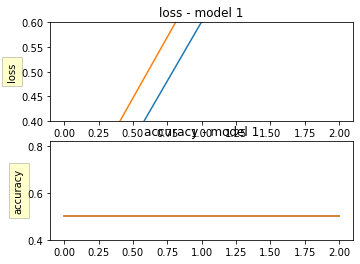

In [80]:
fig, axs = plt.subplots(2, 1)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, 
          bert_model_history,
         y_lim_accuracy_lower=0.40,
         y_lim_accuracy_upper=0.82)

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()